### Part 1. Overview

In this notebook, we will perform forecasting or prediction on the NYC trip data using weather and date-time features. We will also look at feature importance to identify the factors that affect demand in ride-hailing services. We will be using XGBoost for time-series forecasting, with a tree-based booster. Because of this, it is not necessary to perform scaling/standardization of the data.  

### Part 2. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
import numpy as np
import seaborn as sns
import random
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='whitegrid')

### Part 3. Improvements

### Part 4. Analysis

In [2]:
working_df = pd.read_csv('../data/nyc_trip_weather_data_after_eda.csv',index_col=0)
working_df = working_df.set_index('datetime')
working_df.index = pd.to_datetime(working_df.index)

In [3]:
working_df['trip_count'].min(),working_df['trip_count'].max()

(97, 41664)

### Train / Test Split

For time-series data, we can't do the normal random train/test split since there is a time component that we need to be mindful of. For this use-case, we will divide the data approximately to 70% training and 30% testing. This gives us about 8 months of training data and 4 months of testing data. 

In the context of forecasting in real-world applications, we don't have information on the future trends. So it makes sense to use the first 8 months as the training set and the remaining months as the testing set.

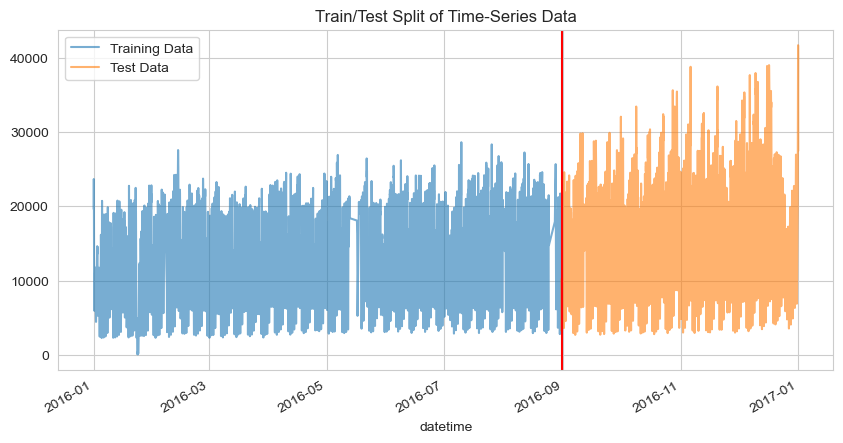

In [4]:
train = working_df.loc[working_df.index < '08-31-2016']
test = working_df.loc[working_df.index >= '08-31-2016']

fig, ax = plt.subplots(figsize=(10, 5))
train['trip_count'].plot(ax=ax, label='Training Data', title='Train/Test Split of Time-Series Data',alpha=0.6)
test['trip_count'].plot(ax=ax, label='Test Data',alpha=0.6)
ax.axvline('08-31-2016',color='red')
ax.legend()
plt.show()

### Model Development

In [5]:
features = ['tempm', 'dewptm', 'hum', 'wspdm', 'wdird', 'vism',
       'pressurem', 'hr', 'day_of_wk', 'weekend', 'month', 'wdire_ENE',
       'wdire_ESE', 'wdire_East', 'wdire_NE', 'wdire_NNE', 'wdire_NNW',
       'wdire_NW', 'wdire_North', 'wdire_SE', 'wdire_SSE', 'wdire_SSW',
       'wdire_SW', 'wdire_South', 'wdire_Variable', 'wdire_WNW', 'wdire_WSW',
       'wdire_West', 'conds_Clear', 'conds_Fog', 'conds_Haze',
       'conds_Heavy Rain', 'conds_Heavy Snow', 'conds_Light Freezing Fog',
       'conds_Light Freezing Rain', 'conds_Light Rain', 'conds_Light Snow',
       'conds_Mostly Cloudy', 'conds_Overcast', 'conds_Partly Cloudy',
       'conds_Rain', 'conds_Scattered Clouds', 'conds_Snow', 'conds_Unknown']
outcome = 'trip_count'
X_train = train[features]
y_train = train[outcome]
X_test = test[features]
y_test = test[outcome]

In [6]:
# setting up model hyperparameters
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       learning_rate=0.01)
# model training
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],verbose=0)

# predict on test set
test['prediction'] = model.predict(X_test)
score = np.sqrt(mean_squared_error(test['trip_count'], test['prediction']))
print(f'Test RMSE: {score:0.2f}')

Test RMSE: 3992.84


In [7]:
normalized_rmse = score / (working_df['trip_count'].max() - working_df['trip_count'].min())
print(normalized_rmse)

0.09605795573867869


The range of the trip count is from 97 to about 41,664 trips which means that with an RMSE of ~4000, we get about a 9% normalized RMSE. Let's look at the predictions for each month and compare it with the true values.

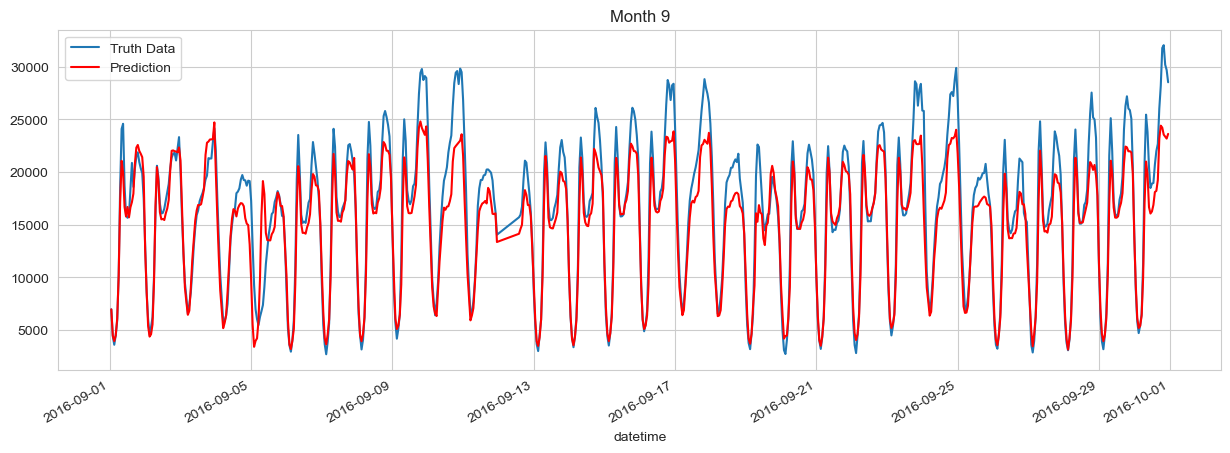

Test RMSE for Month 9: 2443.22


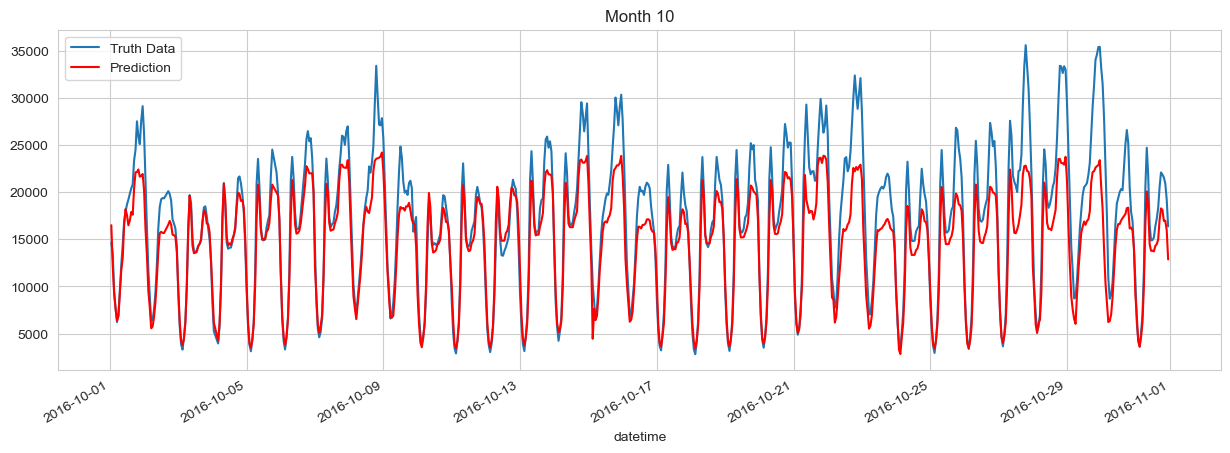

Test RMSE for Month 10: 3422.82


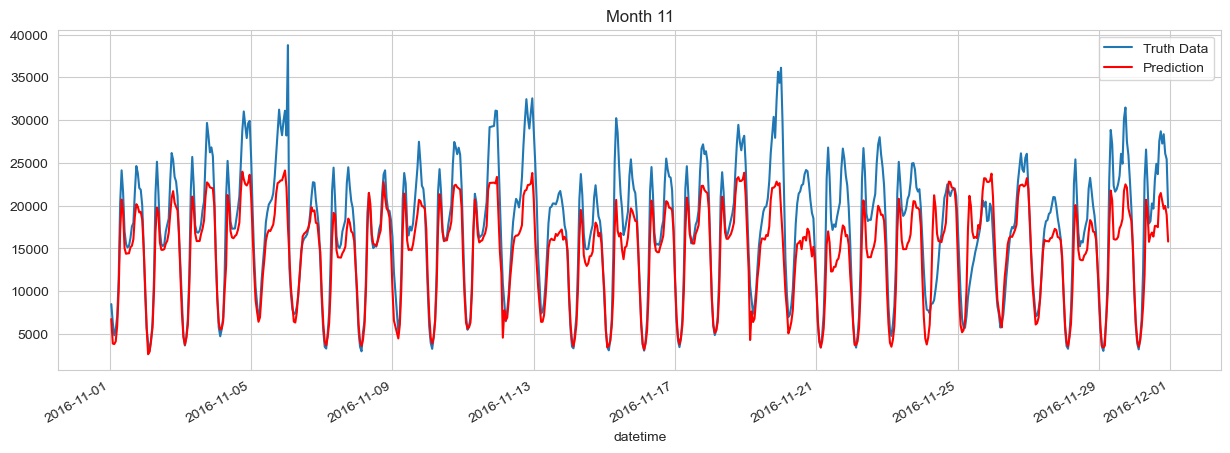

Test RMSE for Month 11: 3935.81


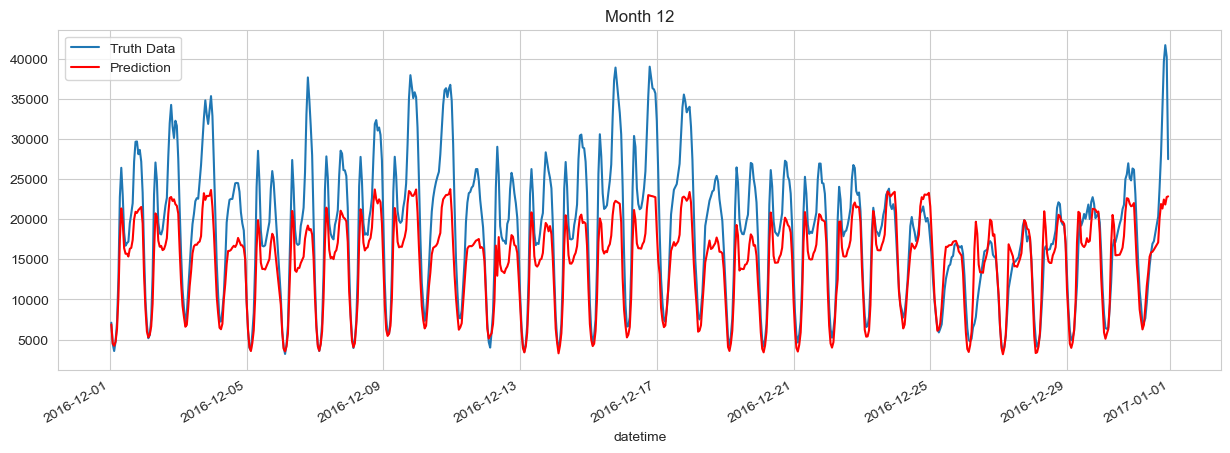

Test RMSE for Month 12: 5555.78


In [8]:
eda = working_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
for month in [9,10,11,12]:
    monthly = eda[eda['month']==month].copy()
    ax = monthly.loc[(monthly.index > monthly.index.min()) & (monthly.index <= monthly.index.max())]['trip_count'] \
        .plot(figsize=(15, 5), title='Month {}'.format(month))
    monthly.loc[(monthly.index > monthly.index.min()) & (monthly.index <= monthly.index.max())]['prediction'] \
        .plot(color='red')
    plt.legend(['Truth Data','Prediction'])
    plt.show()

    score = np.sqrt(mean_squared_error(monthly['trip_count'], monthly['prediction']))
    print(f'Test RMSE for Month {month}: {score:0.2f}')

We can see from this that the model becomes worse at predicting trends the later into the year it is. It can also be observed that it underpredicts the peaks, but does an acceptable job at predicting valleys. 

### Feature Importance

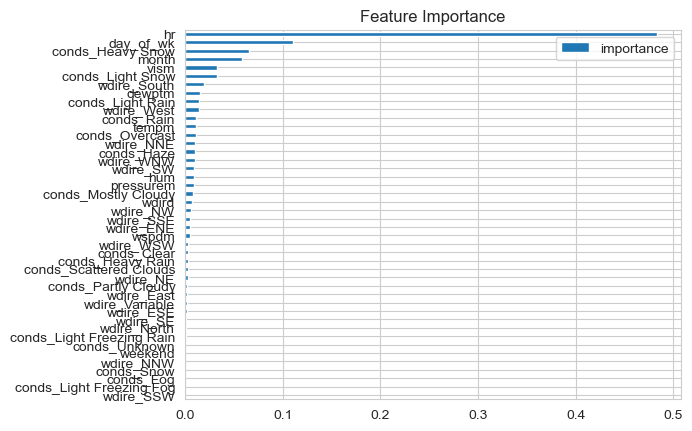

In [9]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Similar to the result of the correlation matrix, hour of day has the highest importance on predicting trip count. This also shows that visibility, light snow, and light rain are also some of the important features.

### Part 5. Conclusion

We developed an XGBoost model to predict trip counts for the months of September to December 2016 using training data from January to August of the same year. Without doing any hyperparameter tuning due to time-constraints, we arrive at an RMSE of 3999.2 (normalized 13%). 

Suggestion for improvement:

- Use at least 2 years of data so that all months in a year are included in the training set. There are variations in the trends between the earlier months and the later months, which might not be captured in the model training.